In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

#### Compute ERP peaks

In [2]:
# # Read data
# evokeds = pd.read_csv('evokeds.csv')
# evokeds['uV'] = evokeds['uV'] * 1000000 - 0.30
# evokeds = evokeds[evokeds.chan == 'Cz']

# all_peaks = pd.DataFrame()
# tones = [1, 2, 3]
# predictability = [True, False]
# accuracies = ["high", "low"]
# segments = [(50, 100), (250, 360), (355, 420), (360, 362), (370, 372), (380, 382), (400, 402)]

# for tone in tones:
#     for target in tones:
#         for predictable in predictability:
#             for accuracy in accuracies:
#                 for segment in segments:
#                     start = segment[0]
#                     end = segment[1]
    
#                     # Segment the data
#                     cond_evokeds = evokeds[(evokeds.tone == tone) &
#                                 (evokeds.target == target) &
#                                 (evokeds.predictable == predictable) &
#                                 (evokeds.accuracy == accuracy)]
    
#                     # Take a time slice
#                     seg = cond_evokeds[cond_evokeds.msec >= start]
#                     seg = seg[seg.msec <= end]
                    
#                     # Calculate the max for each subject
#                     peaks = seg.groupby(['sub'], as_index = False)['uV'].mean()
    
#                     # Create a data frame
#                     peaks['tone'] = tone
#                     peaks['target'] = target
#                     peaks['predictable'] = predictable
#                     peaks['accuracy'] = accuracy
#                     peaks['start'] = start
#                     peaks['end'] = end
    
#                     # Bind to data frame
#                     all_peaks = pd.concat([all_peaks, peaks])
#                     all_peaks = all_peaks.reset_index(drop = True)
#         #             break
#         #         break
#         #     break
#         # break
#     # break
# all_peaks.to_csv('erp_peaks.csv', index = False)
erp_peaks = pd.read_csv('erp_peaks.csv')
erp_peaks

,sub,uV,tone,target,predictable,accuracy,start,end
0,10,0.255889,1,1,True,high,50,100
1,12,-0.468329,1,1,True,high,50,100
2,14,0.053294,1,1,True,high,50,100
3,16,-0.048996,1,1,True,high,50,100
4,17,0.062207,1,1,True,high,50,100
...,...,...,...,...,...,...,...,...
3964,31,-0.232685,3,3,False,low,400,402
3965,32,-0.160840,3,3,False,low,400,402
3966,34,-0.344096,3,3,False,low,400,402
3967,36,-0.318327,3,3,False,low,400,402


#### Compute FFR spectrum peaks

In [3]:
# spectrums = pd.read_csv('spectrums.csv', sep = '\t')
# all_stims_power = pd.DataFrame()
# stim_freqs = [110, 150, 210]

# for stim_freq in stim_freqs:    
#     print(f'{stim_freq} Hz stimulus')

#     # select Fourier frequency nearest to stimulus frequency 
#     idx = np.abs(spectrums.frequency - stim_freq).argmin()
#     hz = spectrums.frequency[idx]
#     power_f0 = spectrums[spectrums.frequency == hz]
#     power_f0 = power_f0[power_f0.tone == stim_freq]

#     # append to df
#     all_stims_power = pd.concat([all_stims_power, power_f0])
#     all_stims_power = all_stims_power.reset_index(drop = True)
# all_stims_power.to_csv('ffr_peaks.csv', index = False)
ffr_peaks = pd.read_csv('ffr_peaks.csv')
ffr_peaks

,subject,predictable,target,tone,frequency,dB
0,2,True,110,110,109.780439,-2.185842
1,2,True,150,110,109.780439,1.132664
2,2,True,210,110,109.780439,-0.974214
3,2,False,110,110,109.780439,-2.950545
4,2,False,150,110,109.780439,1.369111
...,...,...,...,...,...,...
715,41,True,150,210,209.580838,5.132328
716,41,True,210,210,209.580838,3.544135
717,41,False,110,210,209.580838,5.581544
718,41,False,150,210,209.580838,0.152358


#### Combine into one dataframe

In [4]:
# # Combine into one dataframe
# print(len(np.unique(ffr_peaks.subject)))
# print(len(np.unique(erp_peaks['sub'])))
# all_peaks = pd.DataFrame()

# for sub in np.unique(ffr_peaks.subject):
#     # Subset data
#     sub_ffr_peaks = ffr_peaks[ffr_peaks.subject == sub]
#     sub_erp_peaks = erp_peaks[erp_peaks['sub'] == sub]

#     # Match columns
#     sub_erp_peaks = sub_erp_peaks.rename(columns = {'sub': 'subject'})
#     sub_erp_peaks['tone'] = sub_erp_peaks['tone'].replace({1: 110, 2: 150, 3: 210})
#     sub_erp_peaks['target'] = sub_erp_peaks['target'].replace({1: 110, 2: 150, 3: 210})

#     # Merge dfs
#     sub_peaks = sub_erp_peaks.merge(sub_ffr_peaks, left_on = ["subject", "predictable", "tone", "target"], right_on = ["subject", "predictable", "tone", "target"])
#     all_peaks = pd.concat([all_peaks, sub_peaks])
#     all_peaks = all_peaks.reset_index(drop = True)

# all_peaks.to_csv('all_peaks.csv', index = False)
all_peaks = pd.read_csv('all_peaks.csv')
all_peaks

,uV,accuracy,start,end,subject,predictable,target,tone,frequency,dB
0,0.255889,high,50,100,10,True,110,110,109.780439,3.188191
1,0.106929,high,250,360,10,True,110,110,109.780439,3.188191
2,-0.146025,high,355,420,10,True,110,110,109.780439,3.188191
3,-0.159448,high,360,362,10,True,110,110,109.780439,3.188191
4,-0.430519,high,370,372,10,True,110,110,109.780439,3.188191
...,...,...,...,...,...,...,...,...,...,...
3964,0.082625,high,355,420,41,False,210,210,209.580838,0.645166
3965,0.270601,high,360,362,41,False,210,210,209.580838,0.645166
3966,0.060696,high,370,372,41,False,210,210,209.580838,0.645166
3967,0.183549,high,380,382,41,False,210,210,209.580838,0.645166


In [5]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    all_peaks = all_peaks[all_peaks['subject'] != bad]
np.unique(all_peaks['subject'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

## Regressions by target

#### N1

In [7]:
# peaks_tone = all_peaks[all_peaks.tone == 110]

# peak = peaks_tone[peaks_tone.start == 50] # 360, 385, 400
# uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
# # graph.set(ylim = (-2, 1), xlim = (-4, 15))
# # 
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1.png')

# # Regression
# df_110 = df[df.target == 110]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_150 = df[df.target == 150]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_210 = df[df.target == 210]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [8]:
# peaks_tone = all_peaks[all_peaks.tone == 150]

# peak = peaks_tone[peaks_tone.start == 50] # 360, 385, 400
# uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
# # graph.set(ylim = (-2, 1), xlim = (-4, 15))
# # 
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1.png')

# # Regression
# df_110 = df[df.target == 110]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_150 = df[df.target == 150]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_210 = df[df.target == 210]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [9]:
# peaks_tone = all_peaks[all_peaks.tone == 210]

# peak = peaks_tone[peaks_tone.start == 50] # 360, 385, 400
# uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
# # graph.set(ylim = (-2, 1), xlim = (-4, 15))
# # 
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1.png')

# # Regression
# df_110 = df[df.target == 110]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_150 = df[df.target == 150]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_210 = df[df.target == 210]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
# print(slope, intercept, r_value, p_value, std_err)

#### N2

In [10]:
# peaks_tone = all_peaks[all_peaks.tone == 110]

# peak = peaks_tone[peaks_tone.start == 250] 
# uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
# # graph.set(ylim = (-2, 1), xlim = (-4, 15))
# # 
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1.png')

# # Regression
# df_110 = df[df.target == 110]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_150 = df[df.target == 150]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_210 = df[df.target == 210]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [11]:
# peaks_tone = all_peaks[all_peaks.tone == 150]

# peak = peaks_tone[peaks_tone.start == 250] 
# uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
# # graph.set(ylim = (-2, 1), xlim = (-4, 15))
# # 
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1.png')

# # Regression
# df_110 = df[df.target == 110]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_150 = df[df.target == 150]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_210 = df[df.target == 210]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [12]:
# peaks_tone = all_peaks[all_peaks.tone == 210]

# peak = peaks_tone[peaks_tone.start == 250] 
# uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
# # graph.set(ylim = (-2, 1), xlim = (-4, 15))
# # 
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1.png')

# # Regression
# df_110 = df[df.target == 110]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_150 = df[df.target == 150]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_210 = df[df.target == 210]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
# print(slope, intercept, r_value, p_value, std_err)

#### P4

-0.010172960500939174 -0.14724266736089292 -0.056509936328758684 0.7667697673668012 0.0339663580193304
0.010118888879730259 -0.5280339138932914 0.07822936495578804 0.6811430566343872 0.02436974687864584
0.018865059594354458 -0.5452038010141973 0.135747879491743 0.4744547973797726 0.026020000811985466


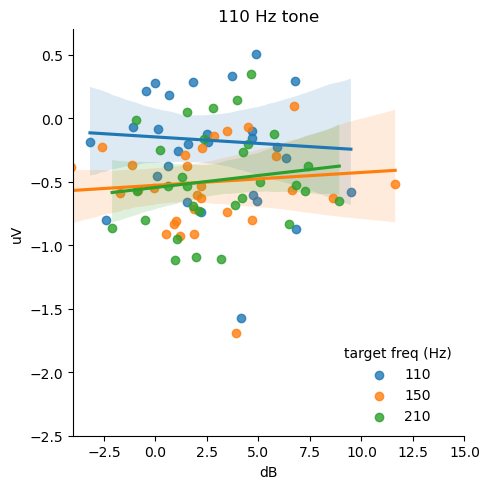

In [41]:
peaks_tone = all_peaks[all_peaks.tone == 110]

peak = peaks_tone[peaks_tone.start == 400] 
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
graph.set(ylim = (-2.5, 0.7), xlim = (-4, 15))
 
ax = plt.gca()
ax.set_title("110 Hz tone")
plt.legend(loc = 'lower right', title = "target freq (Hz)", frameon = False) 
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-1.png')

# Regression
df_110 = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
print(slope, intercept, r_value, p_value, std_err)
df_150 = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
print(slope, intercept, r_value, p_value, std_err)
df_210 = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
print(slope, intercept, r_value, p_value, std_err)

-0.004562193725897012 -0.835267182515248 -0.026104910840801382 0.893071906286691 0.03362184932897191
-0.05499851963753231 -0.3181772654674096 -0.37170431471144677 0.04709709474470989 0.026435273412512818
-0.02288735952088431 -0.7151210037185919 -0.12117903186528964 0.5311977698538243 0.036080622335408506


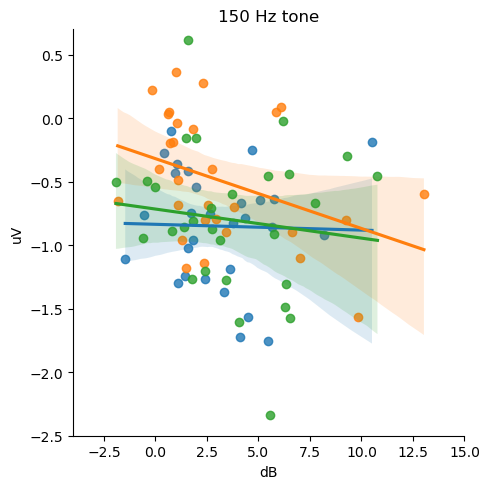

In [40]:
peaks_tone = all_peaks[all_peaks.tone == 150]
peaks_tone = peaks_tone[peaks_tone != 18]


peak = peaks_tone[peaks_tone.start == 380] 
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
graph.set(ylim = (-2.5, 0.7), xlim = (-4, 15))
 
ax = plt.gca()
ax.set_title("150 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-2.png')

# Regression
df_110 = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
print(slope, intercept, r_value, p_value, std_err)
df_150 = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
print(slope, intercept, r_value, p_value, std_err)
df_210 = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
print(slope, intercept, r_value, p_value, std_err)

-0.04267360056435301 -0.567309762752147 -0.36921688245954287 0.044650252411546965 0.02029901079231173
-0.03241198678865707 -0.6390111996170553 -0.2319659401534391 0.21740729665654968 0.025685735528943845
-0.0723279552754983 -0.1780691285408395 -0.40027616217631873 0.02839346944935173 0.03129319802919757


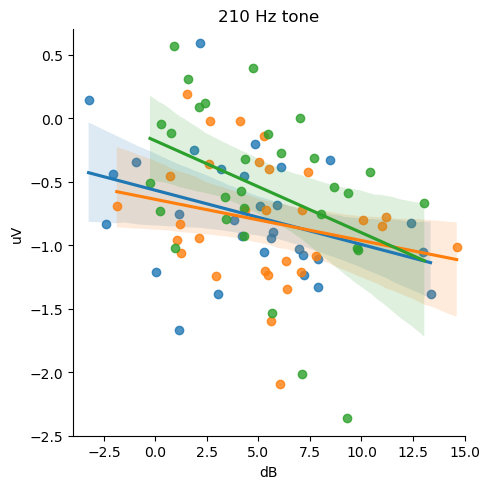

In [39]:
peaks_tone = all_peaks[all_peaks.tone == 210]

peak = peaks_tone[peaks_tone.start == 370] 
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
graph.set(ylim = (-2.5, 0.7), xlim = (-4, 15))
# 
ax = plt.gca()
ax.set_title("210 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-3.png')

# Regression
df_110 = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
print(slope, intercept, r_value, p_value, std_err)
df_150 = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
print(slope, intercept, r_value, p_value, std_err)
df_210 = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
print(slope, intercept, r_value, p_value, std_err)

## Regressions by predictability

### N1

In [16]:
# peaks = all_peaks[all_peaks.tone == 110]
# # peaks = peaks[peaks.target == 110]

# peak = peaks[peaks.start == 50] # 50, 250, 360
# uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# graph.set(ylim = (-0.6, 1.2), xlim = (-2, 13.5))
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'lower right', frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# # Regression
# df_predictable = df[df.predictable == True]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_random = df[df.predictable == False]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [17]:
# peaks = all_peaks[all_peaks.tone == 150]

# peak = peaks[peaks.start == 50] # 50, 250, 360
# uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# graph.set(ylim = (-0.6, 1.2), xlim = (-2, 13.5))
# ax = plt.gca()
# ax.set_title("150 Hz tone")
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-2-by-predictability.png')

# # Regression
# df_predictable = df[df.predictable == True]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_random = df[df.predictable == False]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [18]:
# peaks = all_peaks[all_peaks.tone == 210]

# peak = peaks[peaks.start == 50] # 50, 250, 360
# uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# graph.set(ylim = (-0.6, 1.2), xlim = (-2, 13.5))
# ax = plt.gca()
# ax.set_title("210 Hz tone")
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-3-by-predictability.png')

# # Regression
# df_predictable = df[df.predictable == True]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_random = df[df.predictable == False]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
# print(slope, intercept, r_value, p_value, std_err)

### N2

In [19]:
# peaks_110 = all_peaks[all_peaks.tone == 110]

# peak = peaks_110[peaks_110.start == 250] # 50, 250, 360
# uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# # graph.set(ylim = (0, 2.5), xlim = (-2, 12))
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'lower right', frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# # Regression
# df_predictable = df[df.predictable == True]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_random = df[df.predictable == False]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [20]:
# peaks_110 = all_peaks[all_peaks.tone == 150]

# peak = peaks_110[peaks_110.start == 250] # 50, 250, 360
# uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# # graph.set(ylim = (0, 2.5), xlim = (-2, 12))
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'lower right', frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# # Regression
# df_predictable = df[df.predictable == True]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_random = df[df.predictable == False]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
# print(slope, intercept, r_value, p_value, std_err)

In [21]:
# peaks_110 = all_peaks[all_peaks.tone == 210]

# peak = peaks_110[peaks_110.start == 250] # 50, 250, 360
# uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
# dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
# df = uV
# df['dB'] = dB.dB

# # Plot
# graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# # graph.set(ylim = (0, 2.5), xlim = (-2, 12))
# ax = plt.gca()
# ax.set_title("110 Hz tone")
# plt.legend(loc = 'lower right', frameon = False) 
# plt.tight_layout()
# # plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# # Regression
# df_predictable = df[df.predictable == True]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
# print(slope, intercept, r_value, p_value, std_err)
# df_random = df[df.predictable == False]
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
# print(slope, intercept, r_value, p_value, std_err)

### P4

0.006638135181765699 -0.9655764231195294 0.04563676929130687 0.810744150052565 0.0274599319674595
-0.028694429632031317 -0.45416957030635347 -0.20188642606266213 0.28468414974192063 0.02630725440806079


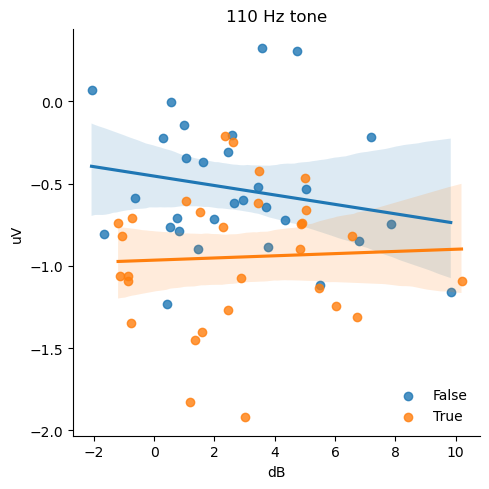

In [22]:
peaks = all_peaks[all_peaks.tone == 110]

peak = peaks[peaks.start == 360] # 50, 250, 360
uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("110 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_predictable = df[df.predictable == True]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
print(slope, intercept, r_value, p_value, std_err)
df_random = df[df.predictable == False]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
print(slope, intercept, r_value, p_value, std_err)

-0.04145901481688362 -0.8200127673380814 -0.2615358602493723 0.16269644018647142 0.028915001713017183
-0.009042917860346108 -0.8769666216787937 -0.05843372223974819 0.7590586324235347 0.029195996341610644


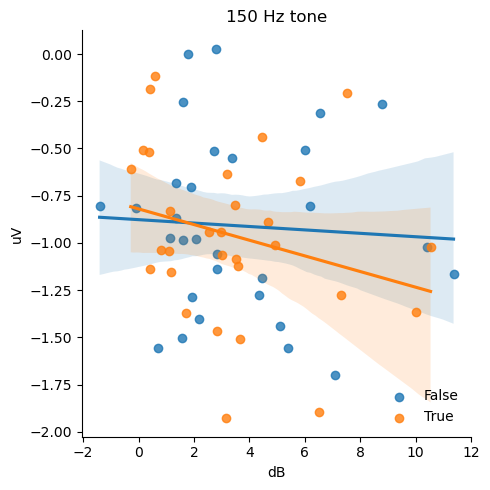

In [23]:
peaks = all_peaks[all_peaks.tone == 150]

peak = peaks[peaks.start == 360] # 50, 250, 360
uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("150 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_predictable = df[df.predictable == True]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
print(slope, intercept, r_value, p_value, std_err)
df_random = df[df.predictable == False]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
print(slope, intercept, r_value, p_value, std_err)

-0.04272558618671572 -0.7196418021957092 -0.35893571657465234 0.05142674994256074 0.020996291110966986
-0.05829975336567132 -0.28554279169902574 -0.43077758843476666 0.01748027731379901 0.02308137415043842


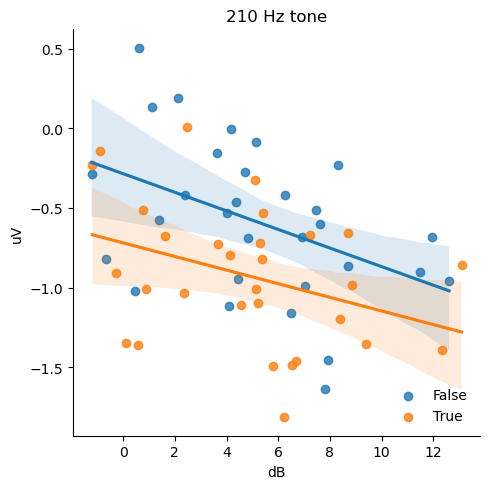

In [24]:
peaks = all_peaks[all_peaks.tone == 210]

peak = peaks[peaks.start == 360] # 50, 250, 360
uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
# graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("210 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_predictable = df[df.predictable == True]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
print(slope, intercept, r_value, p_value, std_err)
df_random = df[df.predictable == False]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
print(slope, intercept, r_value, p_value, std_err)

## Regressions by accuracy

#### P4

0.04948651215045079 -0.7323361468380081 0.2696643753173995 0.3124802341631049 0.047228587903543354
-0.02073873289155139 -0.7504361565872684 -0.1911888678385865 0.5126287403805933 0.030735682882504743


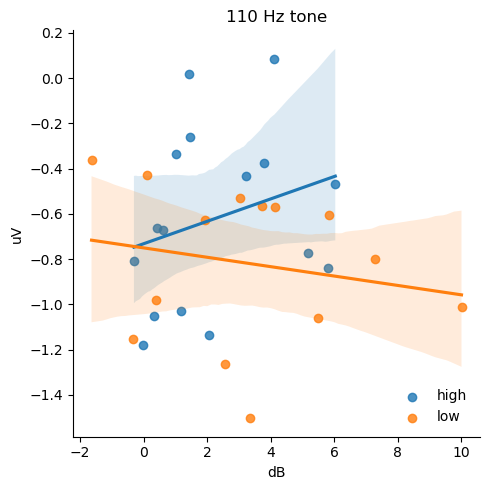

In [25]:
peaks = all_peaks[all_peaks.tone == 110]

peak = peaks[peaks.start == 370] # 50, 250, 360
uV = peak.groupby(['subject', 'accuracy'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'accuracy'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy", legend = False)
# graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("110 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_high_accuracy = df[df.accuracy == "high"]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_high_accuracy.dB, df_high_accuracy.uV)
print(slope, intercept, r_value, p_value, std_err)
df_low_accuracy = df[df.accuracy == "low"]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low_accuracy.dB, df_low_accuracy.uV)
print(slope, intercept, r_value, p_value, std_err)

-0.027666481295169805 -0.7517656758745105 -0.17917468698963776 0.50671102525135 0.040600155772514315
-0.04373871062341045 -0.7839651860011472 -0.31637881199175655 0.27044861396400827 0.03785874048278501


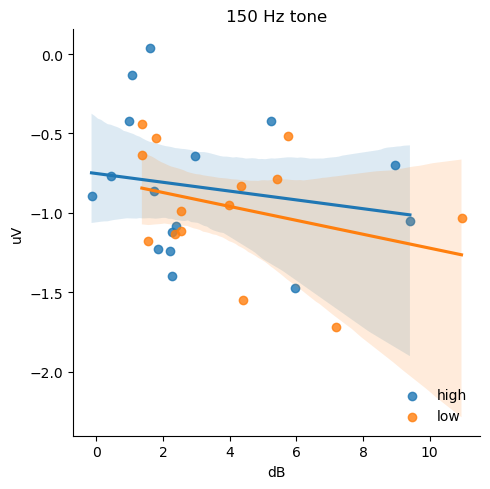

In [26]:
peaks = all_peaks[all_peaks.tone == 150]

peak = peaks[peaks.start == 370] # 50, 250, 360
uV = peak.groupby(['subject', 'accuracy'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'accuracy'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy", legend = False)
# graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("150 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_high_accuracy = df[df.accuracy == "high"]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_high_accuracy.dB, df_high_accuracy.uV)
print(slope, intercept, r_value, p_value, std_err)
df_low_accuracy = df[df.accuracy == "low"]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low_accuracy.dB, df_low_accuracy.uV)
print(slope, intercept, r_value, p_value, std_err)

-0.057473231248192314 -0.39181019820874075 -0.4576093529719526 0.07470134872998971 0.029845810255313854
-0.03203175653744926 -0.6209472499126631 -0.18850890817974864 0.518666972285117 0.04817274040768861


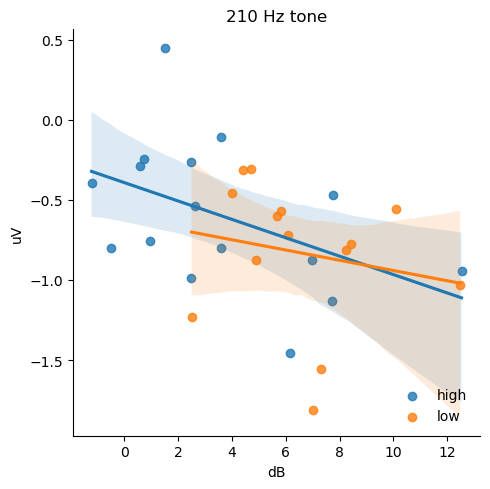

In [27]:
peaks = all_peaks[all_peaks.tone == 210]

peak = peaks[peaks.start == 370] # 50, 250, 360
uV = peak.groupby(['subject', 'accuracy'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'accuracy'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy", legend = False)
# graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("210 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_high_accuracy = df[df.accuracy == "high"]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_high_accuracy.dB, df_high_accuracy.uV)
print(slope, intercept, r_value, p_value, std_err)
df_low_accuracy = df[df.accuracy == "low"]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low_accuracy.dB, df_low_accuracy.uV)
print(slope, intercept, r_value, p_value, std_err)